In [1]:
from pyspark.sql import *
import pyspark.sql.functions as F
import pyspark.sql.types as T 
import string
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import pandas as pd
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')

In [ ]:
#sc.stop()

In [2]:
from pyspark.sql import SparkSession
import pyspark
sc = pyspark.SparkContext(appName="ToxicTwitterComments")
spark = pyspark.sql.SQLContext(sc)

# 1. Load data

In [4]:
##Modify path to train.csv
trainDF = spark.read.csv('train.csv', 
                         header=True, 
                         multiLine=True, 
                         encoding="UTF-8",
                         sep=',',
                         escape='"',
                         inferSchema=True)

# 1.1 Split data

In [5]:
train, test = trainDF.randomSplit([0.6, 0.4], seed = 2018)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 95557
Test Dataset Count: 64014


In [6]:
train.createOrReplaceTempView('train')
test.createOrReplaceTempView('test')

In [7]:
train.printSchema()

root
 |-- id: string (nullable = true)
 |-- comment_text: string (nullable = true)
 |-- toxic: integer (nullable = true)
 |-- severe_toxic: integer (nullable = true)
 |-- obscene: integer (nullable = true)
 |-- threat: integer (nullable = true)
 |-- insult: integer (nullable = true)
 |-- identity_hate: integer (nullable = true)



In [8]:
spark.sql('''
SELECT * FROM train
limit(10)
''').toPandas()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
4,00024b59235015f3,Virgin\nMy only warning? You'll block me? Well...,1,0,1,0,1,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,0002bfc2abe2a51f,"""*::::::::I believe that you're confusing """"pr...",0,0,0,0,0,0
8,0002eeaf4c0cdf35,But isnt it against the rules to edit if you a...,0,0,0,0,0,0
9,00030003d620f7a8,"""\nseems about right. nableezy - """,0,0,0,0,0,0


# 2. Data Cleaning

In [9]:
stop_words = list(set(stopwords.words('english')))
stop_words.remove('not')

In [10]:
def clean(lines):
    lines = lines.lower().translate(str.maketrans('', '', string.punctuation))
    lines = lines.split(' ')
    filtered_sentence = [w for w in lines if not w in stop_words]
    cleaned_line = []
    for w in filtered_sentence:
        word = PorterStemmer().stem(w)
        cleaned_line.append(word)
    return ' '.join(cleaned_line)

In [11]:
type(clean("'Hey man, I'm really not trying to edit war.'"))

str

In [12]:
spark.udf.register("clean", clean, T.StringType())

<function __main__.clean>

In [13]:
#Get rid of limit
df_train=spark.sql("""
SELECT clean(comment_text) cleaned_comment, toxic, severe_toxic,obscene,threat,insult,identity_hate
FROM train
LIMIT 30000
""")

In [14]:
#cleaning test data
df_test=spark.sql("""
SELECT clean(comment_text) cleaned_comment, toxic, severe_toxic,obscene,threat,insult,identity_hate
FROM test
LIMIT 20000
""")

In [36]:
# get a column of array<string> for word2vec
from pyspark.sql.functions import *
df_train2=df_train.withColumn("cleaned_comment2",split(df_train['cleaned_comment'], ' '))
df_test2 = df_test.withColumn("cleaned_comment2",split(df_test['cleaned_comment'], ' '))

In [38]:
df_train2.toPandas().head()

,cleaned_comment,toxic,severe_toxic,obscene,threat,insult,identity_hate,cleaned_comment2
0,explanation\nwhi edit made usernam hardcor met...,0,0,0,0,0,0,"[explanation\nwhi, edit, made, usernam, hardco..."
1,daww match background colour im seemingli stuc...,0,0,0,0,0,0,"[daww, match, background, colour, im, seemingl..."
2,hey man im realli not tri edit war guy constan...,0,0,0,0,0,0,"[hey, man, im, realli, not, tri, edit, war, gu..."
3,sir hero chanc rememb page that,0,0,0,0,0,0,"[sir, hero, chanc, rememb, page, that]"
4,virgin\nmi warn youll block well fck probabl g...,1,0,1,0,1,0,"[virgin\nmi, warn, youll, block, well, fck, pr..."


In [17]:
df_train2.printSchema()

root
 |-- cleaned_comment: string (nullable = true)
 |-- toxic: integer (nullable = true)
 |-- severe_toxic: integer (nullable = true)
 |-- obscene: integer (nullable = true)
 |-- threat: integer (nullable = true)
 |-- insult: integer (nullable = true)
 |-- identity_hate: integer (nullable = true)
 |-- cleaned_comment2: array (nullable = true)
 |    |-- element: string (containsNull = true)



# 2.1 Data Exploration

### Exploring data with 5000 rows of comments from training dataset.

In [50]:
df_explore=spark.sql("""
SELECT clean(comment_text) cleaned_comment, toxic, severe_toxic,obscene,threat,insult,identity_hate
FROM train
LIMIT 5000
""")
df_explore2=df_explore.withColumn("cleaned_comment2",split(df_explore['cleaned_comment'], ' '))

In [51]:
# most frequent word in toxic|severe_toxic|obscene|threat|insult|identity_hate comments
df_explore_toxic = df_explore2.filter(df_explore2.toxic != 0)
df_explore_severe_toxic = df_explore2.filter(df_explore2.severe_toxic != 0)
df_explore_obscene = df_explore2.filter(df_explore2.obscene != 0)
df_explore_threat = df_explore2.filter(df_explore2.threat != 0)
df_explore_insult = df_explore2.filter(df_explore2.insult != 0)
df_explore_identity_hate = df_explore2.filter(df_explore2.identity_hate != 0)

In [52]:
import os
from os import path
from wordcloud import WordCloud
import matplotlib.pyplot as plt
def wordcloud(df):
    d = {}
    for a, x in df.values:
        d[a] = x
    wordcloud = WordCloud()
    wordcloud.generate_from_frequencies(frequencies=d)
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()
    return

In [53]:
df_explore_toxic = df_explore_toxic.select(F.explode("cleaned_comment2").alias("words")).groupBy("words").count().orderBy(desc("count"))
df_explore_toxic.show()

+----------+-----+
|     words|count|
+----------+-----+
|      fuck|  670|
|          |  589|
|   chester|  261|
|marcolfuck|  260|
|         u|  249|
|   useless|  229|
|       bot|  218|
|   up
shut|  208|
|      like|  191|
|       not|  185|
|      cant|  167|
|      keep|  150|
|    nigger|  148|
|      
you|  137|
|       get|  118|
|      homo|   95|
| wikipedia|   90|
|   friggen|   89|
|    gayfag|   89|
|     block|   87|
+----------+-----+
only showing top 20 rows



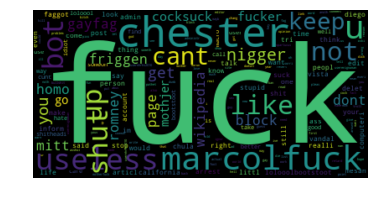

In [54]:
wordcloud(df_explore_toxic.toPandas())

In [55]:
df_explore_severe_toxic = df_explore_severe_toxic.select(F.explode("cleaned_comment2").alias("words")).groupBy("words").count().orderBy(desc("count"))
df_explore_severe_toxic.show()

+----------+-----+
|     words|count|
+----------+-----+
|      fuck|  467|
|   chester|  261|
|marcolfuck|  260|
|         u|  229|
|   useless|  223|
|       bot|  217|
|   up
shut|  208|
|    nigger|  137|
|      cant|  136|
|      keep|  135|
|      
you|  135|
|    fucker|   82|
|  cocksuck|   79|
|   mothjer|   78|
|          |   23|
|        go|   10|
|      fack|    9|
|      shit|    9|
|       wut|    9|
|       get|    8|
+----------+-----+
only showing top 20 rows



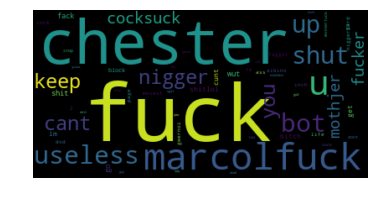

In [56]:
wordcloud(df_explore_severe_toxic.toPandas())

In [57]:
df_explore_obscene = df_explore_obscene.select(F.explode("cleaned_comment2").alias("words")).groupBy("words").count().orderBy(desc("count"))
df_explore_obscene.show()

+----------+-----+
|     words|count|
+----------+-----+
|      fuck|  673|
|          |  295|
|   chester|  261|
|marcolfuck|  260|
|         u|  238|
|   useless|  223|
|       bot|  217|
|   up
shut|  208|
|      like|  146|
|      homo|   89|
|    romney|   87|
|      mitt|   87|
|  cocksuck|   84|
|    fucker|   84|
|       get|   83|
|   mothjer|   78|
|       not|   70|
|     block|   65|
|      dont|   51|
|      page|   47|
+----------+-----+
only showing top 20 rows



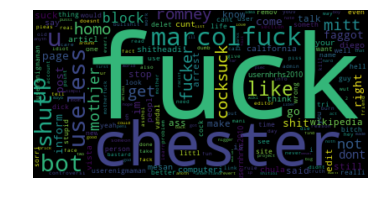

In [58]:
wordcloud(df_explore_obscene.toPandas())

In [59]:
df_explore_threat = df_explore_threat.select(F.explode("cleaned_comment2").alias("words")).groupBy("words").count().orderBy(desc("count"))
df_explore_threat.show()

+------+-----+
| words|count|
+------+-----+
|      |   21|
|  kill|   10|
|    im|    8|
|    go|    6|
|   die|    6|
|vandal|    5|
| death|    3|
|revert|    3|
|  page|    3|
|  edit|    3|
|  like|    3|
| 

you|    3|
|   not|    3|
|    

|    3|
|  dont|    3|
|  agre|    2|
| think|    2|
|  warn|    2|
|  time|    2|
| would|    2|
+------+-----+
only showing top 20 rows



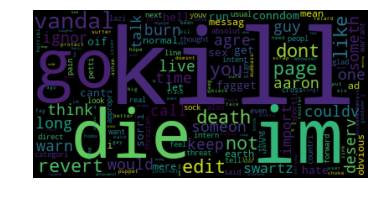

In [60]:
wordcloud(df_explore_threat.toPandas())

In [61]:
df_explore_insult = df_explore_insult.select(F.explode("cleaned_comment2").alias("words")).groupBy("words").count().orderBy(desc("count"))
df_explore_insult.show()

+----------------+-----+
|           words|count|
+----------------+-----+
|            fuck|  384|
|                |  318|
|               u|  241|
|         useless|  225|
|             bot|  218|
|            like|  153|
|            cant|  150|
|          nigger|  142|
|            keep|  140|
|            
you|  136|
|             not|  104|
|            homo|   90|
|         friggen|   89|
|          gayfag|   89|
|            mitt|   87|
|          romney|   87|
|        cocksuck|   83|
|          fucker|   83|
|         mothjer|   78|
|lolooolbootstoot|   67|
+----------------+-----+
only showing top 20 rows



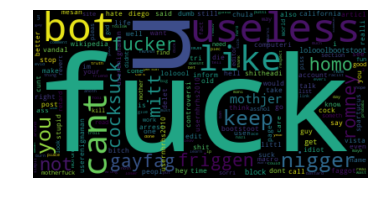

In [62]:
wordcloud(df_explore_insult.toPandas())

In [63]:
df_explore_identity_hate = df_explore_identity_hate.select(F.explode("cleaned_comment2").alias("words")).groupBy("words").count().orderBy(desc("count"))
df_explore_identity_hate.show()

+--------------+-----+
|         words|count|
+--------------+-----+
|        nigger|  142|
|          cant|  141|
|          keep|  135|
|          
you|  135|
|          like|  101|
|          homo|   92|
|          mitt|   87|
|        romney|   87|
|              |   43|
|          fuck|   31|
|           is
|   23|
|
usernhrhs2010|   22|
| usernhrhs2010|   22|
| userenigmaman|   22|
|
userenigmaman|   21|
|     wikipedia|   14|
|         block|   12|
|             u|   12|
|            go|   11|
|          cunt|   10|
+--------------+-----+
only showing top 20 rows



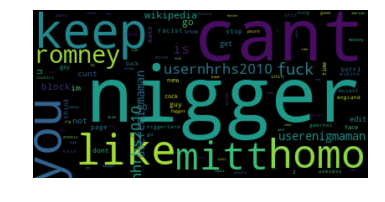

In [64]:
wordcloud(df_explore_identity_hate.toPandas())

# 2.2 Visualizing Word2Vec via PCA

In [76]:
from pyspark.ml.feature import Word2Vec
from pyspark.ml import Pipeline

word2Vec = Word2Vec(vectorSize=30, seed=42, inputCol="cleaned_comment2", outputCol="features")
model = word2Vec.fit(df_explore2)
model.getVectors().show()
wvfeature = model.transform(df_explore2)
###
#pipeline_w2v = Pipeline(stages=[word2Vec])
#pipelineModel_w2v = pipeline_w2v.fit(df_train2)
#wvfeature = pipelineModel_w2v.transform(df_train2)

+--------------------+--------------------+
|                word|              vector|
+--------------------+--------------------+
|            incident|[-0.0031104383524...|
|             serious|[-0.0661215782165...|
|           forgotten|[0.01953295245766...|
|               mario|[-0.0518282726407...|
|              justif|[-0.0778183117508...|
|               lover|[0.01077024266123...|
|           regularli|[-0.0169724225997...|
|             speaker|[-0.0153403934091...|
|                rate|[-0.0472344420850...|
|                2014|[-0.0016733994707...|
|                mole|[0.03772790357470...|
|              assert|[-0.0584242939949...|
|                  45|[-0.0132676446810...|
|         noticeboard|[0.02269356511533...|
|                rage|[0.00235348893329...|
|              arbcom|[0.02054739743471...|
|                 mew|[-0.0330215692520...|
|             michael|[0.00298468885011...|
|                 4th|[0.02016168460249...|
|stylebackgroundco...|[0.0506928

In [77]:
word = 'rage'
topN = 5

synonymsDF = model.findSynonyms(word, topN).toPandas()

In [78]:
synonymsDF[['word']].head(topN)

,word
0,territori
1,squar
2,differ
3,publish
4,tabl


In [79]:
wordVectorsDF = model.getVectors()
from pyspark.ml.feature import PCA
dfW2V = wordVectorsDF.select('vector').withColumnRenamed('vector','features')

numComponents = 3
pca = PCA(k = numComponents, inputCol = 'features', outputCol = 'pcaFeatures')
model = pca.fit(dfW2V)
dfComp = model.transform(dfW2V).select("pcaFeatures")

In [80]:
dfComp.show()

+--------------------+
|         pcaFeatures|
+--------------------+
|[-0.0188583568357...|
|[0.11712241142307...|
|[-0.0333241584126...|
|[0.11706829172752...|
|[0.30270522122957...|
|[-0.0733281775831...|
|[0.06117173801868...|
|[0.07663453279279...|
|[0.05101108701251...|
|[0.25397305191346...|
|[-0.1794123430154...|
|[0.13406860053066...|
|[0.09183460675993...|
|[0.06026685347393...|
|[0.05052508228983...|
|[0.06237405634071...|
|[0.38072269320191...|
|[0.02943242517804...|
|[0.01034630778948...|
|[0.07714530662182...|
+--------------------+
only showing top 20 rows



In [83]:
def topNwordsToPlot(dfComp,wordVectorsDF,word,nwords):
    compX = np.asarray(dfComp.map(lambda vec: vec[0][0]).collect())
    compY = np.asarray(dfComp.map(lambda vec: vec[0][1]).collect())
    compZ = np.asarray(dfComp.map(lambda vec: vec[0][2]).collect())

    words = np.asarray(wordVectorsDF.select('word').toPandas().values.tolist())
    Feat = np.asarray(wordVectorsDF.select('vector').rdd.map(lambda v: np.asarray(v[0])).collect())

    Nw = words.shape[0]                # total number of words
    ind_star = np.where(word == words) # find index associated to 'word' 
    wstar = Feat[ind_star,:][0][0]     # vector associated to 'word'
    nwstar = math.sqrt(np.dot(wstar,wstar)) # norm of vector assoicated with 'word'

    dist = np.zeros(Nw) # initialize vector of distances
    i = 0
    for w in Feat: # loop to compute cosine distances between 'word' and the rest of the words 
        den = math.sqrt(np.dot(w,w))*nwstar  # denominator of cosine distance
        dist[i] = math.fabs( np.dot(wstar,w) )/den   # cosine distance to each word
        i = i + 1

    indexes = np.argpartition(dist,-(nwords+1))[-(nwords+1):]
    di = []
    for j in range(nwords+1):
        di.append(( words[indexes[j]], dist[indexes[j]], compX[indexes[j]], compY[indexes[j]], compZ[indexes[j]] ) )

    result=[]
    for elem in sorted(di,key=lambda x: x[1],reverse=True):
        result.append((elem[0][0], elem[2], elem[3], elem[4]))
    
    return pd.DataFrame(result,columns=['word','X','Y','Z'])

In [84]:
dfComp = dfComp.select('pcaFeatures').rdd

/Users/Shelly/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


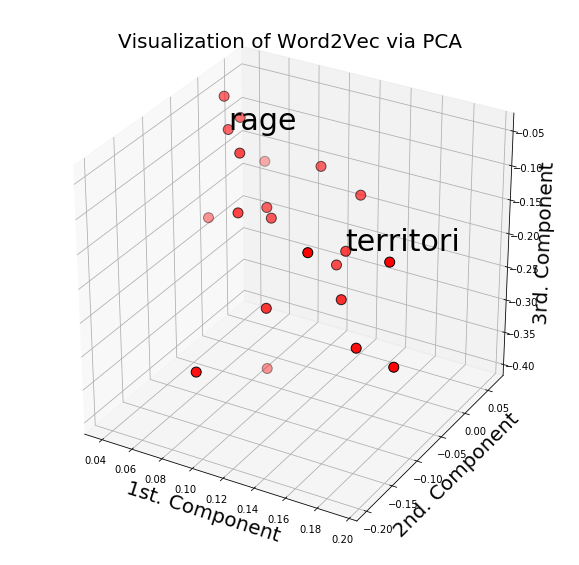

In [85]:
word = 'rage'
nwords = 20
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#############
import math
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
r = topNwordsToPlot(dfComp,wordVectorsDF,word,nwords)

############
fs=20 #fontsize
w = r['word']
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

height = 10
width = 10
fig.set_size_inches(width, height)

ax.scatter(r['X'], r['Y'], r['Z'], color='red', s=100, marker='o', edgecolors='black')
for i, txt in enumerate(w):
    if(i<2):
        ax.text(r['X'].ix[i],r['Y'].ix[i],r['Z'].ix[i], '%s' % (txt), size=30, zorder=1, color='k')
    #if((i==4) or (i==5)):
    #    ax.text(r['X'].ix[i],r['Y'].ix[i],r['Z'].ix[i], '%s' % (txt), size=30, zorder=1, color='k')    
ax.set_xlabel('1st. Component', fontsize=fs)
ax.set_ylabel('2nd. Component', fontsize=fs)
ax.set_zlabel('3rd. Component', fontsize=fs)
ax.set_title('Visualization of Word2Vec via PCA', fontsize=fs)
ax.grid(True)
plt.show()

PCA is used as a way to reduce dimensions so that we can visualize the proximity among words. Another way of doing so is to limit the vector space under 2-D or 3-D. This way, the clustering demonstrates the close proximity among words directly.

In [86]:
from pyspark.ml.clustering import KMeans
vocabSize = wordVectorsDF.count()
K = int(math.floor(math.sqrt(float(vocabSize)/2)))
         # K ~ sqrt(n/2) this is a rule of thumb for choosing K,
         # where n is the number of words in the model
         # feel free to choose K with a fancier algorithm

dfW2V = wordVectorsDF.select('vector').withColumnRenamed('vector','features')
kmeans = KMeans(k=K, seed=1)
modelK = kmeans.fit(dfW2V)
labelsDF = modelK.transform(dfW2V).select('prediction').withColumnRenamed('prediction','labels')

print("Number of Clusters (K) Used: ", K)

Number of Clusters (K) Used:  44


# 3. Feature Engineering

## 3.1 Word2Vec

In [17]:
from pyspark.ml.feature import Word2Vec
from pyspark.ml import Pipeline

word2Vec = Word2Vec(vectorSize=80, seed=42, inputCol="cleaned_comment2", outputCol="features")

pipeline_w2v = Pipeline(stages=[word2Vec])
pipelineModel_w2v = pipeline_w2v.fit(df_train2)
wvfeature = pipelineModel_w2v.transform(df_train2)
wvfeature_test = pipelineModel_w2v.transform(df_test2)

In [18]:
wvfeature.show(2)

+--------------------+-----+------------+-------+------+------+-------------+--------------------+--------------------+
|     cleaned_comment|toxic|severe_toxic|obscene|threat|insult|identity_hate|    cleaned_comment2|            features|
+--------------------+-----+------------+-------+------+------+-------------+--------------------+--------------------+
|explanation
whi e...|    0|           0|      0|     0|     0|            0|[explanation
whi,...|[0.01265160473822...|
|daww match backgr...|    0|           0|      0|     0|     0|            0|[daww, match, bac...|[-0.0468042603058...|
+--------------------+-----+------------+-------+------+------+-------------+--------------------+--------------------+
only showing top 2 rows



Now we get the Word2Vec features， we can follow the procedure like TF-IDF to build another model and compare the performance. 

## 3.2 TF-IDF

In [19]:
from __future__ import print_function
from pyspark.ml.feature import HashingTF, IDF, Tokenizer
from pyspark.ml import Pipeline
from pyspark.sql import SparkSession

In [20]:
#TFIDF processing pipeline
tokenizer = Tokenizer(inputCol="cleaned_comment", outputCol="words")
hashingTF = HashingTF(inputCol=tokenizer.getOutputCol(), outputCol="rawFeatures")
idf = IDF(inputCol="rawFeatures", outputCol="features")
pipeline = Pipeline(stages=[tokenizer, hashingTF, idf])
pipelineModel = pipeline.fit(df_train)
rescaledData = pipelineModel.transform(df_train)
rescaledData_test = pipelineModel.transform(df_test)

In [24]:
#Save as Parquet for faster read
#rescaledData.write.parquet("rescaledData.parquet")

In [25]:
#rescaledData = spark.read.parquet("rescaledData.parquet")

# 4. Modelling (LR)

## 4.1 Training, Testing and Evaluation

Adjust weight to balance data

In [21]:
#get weight to adjust unbalanced
def weight_ratio(predictions,class_name):
    ###### lam is the coefficient timed by the weight, can be tuned
    lam = 1
    pos_lab=predictions[predictions[class_name]==1].count()
    neg_lab=predictions[predictions[class_name]==0].count()
    return neg_lab/pos_lab*lam

In [22]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import LogisticRegression
evaluator = BinaryClassificationEvaluator()

def recall_precision(predictions):
    TP=predictions[(predictions.label==1)&(predictions.prediction==1)].count()
    FP=predictions[(predictions.label==0)&(predictions.prediction==1)].count()
    TN=predictions[(predictions.label==0)&(predictions.prediction==0)].count()
    FN=predictions[(predictions.label==1)&(predictions.prediction==0)].count()
    print('TP: {0}, FP: {1}, TN: {2}, FN: {3}'.format(TP,FP,TN,FN))
    recall=TP/(TP+FN)
    precision=TP/(TP+FP)
    f1=2 * precision * recall / (precision + recall)
    return recall, precision, f1

In [23]:
class_name = ["toxic", 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [29]:
results = []
for name in class_name:
    temp = []
    train=rescaledData.select("features",name)
    test = rescaledData_test.select("features",name)
    ratio=weight_ratio(train,name)
    train=train.withColumn("weight", F.when(train[name]==1,ratio).otherwise(1))
    lr = LogisticRegression(featuresCol = 'features',weightCol="weight",labelCol = name, maxIter=10,regParam = 0.03, elasticNetParam =1)
    lrModel = lr.fit(train)
    print('Classification model for ' + str(name) + " Eval on train dataset")
    predictions_train = lrModel.transform(train)
    predictions_train = predictions_train.select(predictions_train[name].alias("label"), 'rawPrediction', 'prediction', 'probability')
    auc = evaluator.evaluate(predictions_train, {evaluator.metricName: "areaUnderROC"})
    temp.append(auc)
    print("Train Area Under ROC: " + str(auc))
    recall, precision, f1 = recall_precision(predictions_train)
    temp.append(recall)
    temp.append(precision)
    temp.append(f1)
    print("Precision: " + str(precision))
    print("Recall: " + str(recall))
    print("F1 score: " + str(f1))
    print('-----------------------')
    predictions = lrModel.transform(test)
    predictions=predictions.select(predictions[name].alias("label"), 'rawPrediction', 'prediction', 'probability')
    print('Classification model for ' + str(name)+ " Eval on test dataset")
    auc = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"}) 
    print("Test Area Under ROC: " + str(auc))
    temp.append(auc)
    recall, precision, f1 = recall_precision(predictions)
    temp.append(recall)
    temp.append(precision)
    temp.append(f1)
    results.append(temp)
    print("Precision: " + str(precision))
    print("Recall: " + str(recall))
    print("F1 score: " + str(f1))
    print('=======================')

Classification model for toxic Eval on train dataset
Train Area Under ROC: 0.7787542500633686
TP: 2503, FP: 13536, TN: 13579, FN: 382
Precision: 0.15605711079244342
Recall: 0.8675909878682843
F1 score: 0.26453181145635174
-----------------------
Classification model for toxic Eval on test dataset
Test Area Under ROC: 0.775155393348648
TP: 1704, FP: 8962, TN: 9062, FN: 272
Precision: 0.15975998499906244
Recall: 0.8623481781376519
F1 score: 0.26957759848125296
Classification model for severe_toxic Eval on train dataset
Train Area Under ROC: 0.9222860047876548
TP: 291, FP: 11562, TN: 18127, FN: 20
Precision: 0.02455074664641863
Recall: 0.9356913183279743
F1 score: 0.04784610325550805
-----------------------
Classification model for severe_toxic Eval on test dataset
Test Area Under ROC: 0.9180481186958446
TP: 178, FP: 7730, TN: 12079, FN: 13
Precision: 0.022508851795649976
Recall: 0.9319371727748691
F1 score: 0.04395604395604395
Classification model for obscene Eval on train dataset
Train 

In [40]:
df_col = ['auc_train','precision_train','recall_train','f1_train', 'auc_test','precision_test','recall_test','f1_test']

In [41]:
results_TFIDF = pd.DataFrame(results, columns = df_col)

In [49]:
index_dict = {}
for i in range(len(class_name)):
    index_dict.update({i:class_name[i]})
results_TFIDF = results_TFIDF.rename(index = index_dict)
#results_TFIDF.to_csv{tfidf_results.csv}

In [52]:
#TFIDF Evaluation
results_TFIDF

,auc_train,precision_train,recall_train,f1_train,auc_test,precision_test,recall_test,f1_test
toxic,0.778754,0.867591,0.156057,0.264532,0.775155,0.862348,0.159760,0.269578
severe_toxic,0.922286,0.935691,0.024551,0.047846,0.918048,0.931937,0.022509,0.043956
obscene,0.838934,0.845105,0.103443,0.184324,0.831075,0.837275,0.100614,0.179641
threat,0.981031,0.932584,0.069983,0.130196,0.890805,0.526316,0.035800,0.067039
insult,0.824533,0.875497,0.097861,0.176044,0.819934,0.873239,0.097869,0.176011
identity_hate,0.925344,0.715356,0.136137,0.228743,0.898716,0.622222,0.118268,0.198758


In [60]:
results_w2v = []
for name in class_name:
    temp = []
    train=wvfeature.select("features",name)
    test = wvfeature_test.select("features",name)
    ratio=weight_ratio(train,name)
    train=train.withColumn("weight", F.when(train[name]==1,ratio).otherwise(1))
    lr = LogisticRegression(featuresCol = 'features',weightCol="weight",labelCol = name, maxIter=10,regParam = 0.01, elasticNetParam =1)
    lrModel = lr.fit(train)
    print('Classification model for ' + str(name) + " Eval on train dataset")
    predictions_train = lrModel.transform(train)
    predictions_train = predictions_train.select(predictions_train[name].alias("label"), 'rawPrediction', 'prediction', 'probability')
    auc = evaluator.evaluate(predictions_train, {evaluator.metricName: "areaUnderROC"})
    temp.append(auc)
    print("Train Area Under ROC: " + str(auc))
    recall, precision, f1 = recall_precision(predictions_train)
    temp.append(recall)
    temp.append(precision)
    temp.append(f1)
    print("Precision: " + str(precision))
    print("Recall: " + str(recall))
    print("F1 score: " + str(f1))
    print('-----------------------')
    predictions = lrModel.transform(test)
    predictions=predictions.select(predictions[name].alias("label"), 'rawPrediction', 'prediction', 'probability')
    print('Classification model for ' + str(name)+ " Eval on test dataset")
    auc = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"}) 
    temp.append(auc)
    print("Test Area Under ROC: " + str(auc))
    recall, precision, f1 = recall_precision(predictions)
    temp.append(recall)
    temp.append(precision)
    temp.append(f1)
    results_w2v.append(temp)
    print("Precision: " + str(precision))
    print("Recall: " + str(recall))
    print("F1 score: " + str(f1))
    print('=======================')

Classification model for toxic Eval on train dataset
Train Area Under ROC: 0.93225144459818
TP: 2271, FP: 2523, TN: 24592, FN: 614
Precision: 0.4737171464330413
Recall: 0.7871750433275563
F1 score: 0.5914832660502669
-----------------------
Classification model for toxic Eval on test dataset
Test Area Under ROC: 0.9330143310941432
TP: 1555, FP: 1647, TN: 16377, FN: 421
Precision: 0.48563397876327297
Recall: 0.7869433198380567
F1 score: 0.600617999227501
Classification model for severe_toxic Eval on train dataset
Train Area Under ROC: 0.9814754866607794
TP: 282, FP: 1351, TN: 28338, FN: 29
Precision: 0.1726883037354562
Recall: 0.9067524115755627
F1 score: 0.2901234567901234
-----------------------
Classification model for severe_toxic Eval on test dataset
Test Area Under ROC: 0.9809946771775708
TP: 174, FP: 892, TN: 18917, FN: 17
Precision: 0.16322701688555347
Recall: 0.9109947643979057
F1 score: 0.2768496420047733
Classification model for obscene Eval on train dataset
Train Area Under 

In [61]:
results_w2vDF = pd.DataFrame(results_w2v, columns = df_col)

In [62]:
results_w2vDF = results_w2vDF.rename(index = index_dict)
#results_w2vDF.to_csv('w2v_results.csv')

In [63]:
#Word2Vec Evaluation
results_w2vDF

,auc_train,precision_train,recall_train,f1_train,auc_test,precision_test,recall_test,f1_test
toxic,0.932251,0.787175,0.473717,0.591483,0.933014,0.786943,0.485634,0.600618
severe_toxic,0.981475,0.906752,0.172688,0.290123,0.980995,0.910995,0.163227,0.276850
obscene,0.960846,0.840149,0.434755,0.572998,0.961759,0.836329,0.433546,0.571059
threat,0.952631,0.865169,0.028731,0.055616,0.943539,0.859649,0.027952,0.054144
insult,0.951098,0.819868,0.372331,0.512099,0.950987,0.817907,0.376563,0.515699
identity_hate,0.952161,0.857678,0.084346,0.153588,0.940807,0.838889,0.087944,0.159199


# AUC plotting

In [64]:
##########This part is used for overlaying test ROC on train ROC plot. If only train ROC needed, use the 
##########below section. Takes LONG time to run!
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import LogisticRegression
import numpy as np
evaluator = BinaryClassificationEvaluator()

def recall_precision_auc(predictions):
    TP=predictions[(predictions.label==1)&(predictions.prediction==1)].count()
    FP=predictions[(predictions.label==0)&(predictions.prediction==1)].count()
    TN=predictions[(predictions.label==0)&(predictions.prediction==0)].count()
    FN=predictions[(predictions.label==1)&(predictions.prediction==0)].count()
    print('TP: {0}, FP: {1}, TN: {2}, FN: {3}'.format(TP,FP,TN,FN))
    recall=TP/(TP+FN)
    precision=TP/(TP+FP)
    f1=2 * precision * recall / (precision + recall)
    tpr = TP/(TP+FN)
    fpr = FP/(TN+FP)
    return recall, precision, f1, tpr, fpr
#for roc curve
roc_list = ['toxic']
tpr_train = []
fpr_train = []
tpr_test = []
fpr_test = []
for th in np.linspace(0, 1, 10, endpoint=False):
    for name in roc_list:
        train=rescaledData.select("features",name)
        test = rescaledData_test.select("features",name)
        ratio=weight_ratio(train,name)
        train=train.withColumn("weight", F.when(train[name]==1,ratio).otherwise(1))
        lr = LogisticRegression(featuresCol = 'features',weightCol="weight",labelCol = name, maxIter=10,regParam = 0.03, elasticNetParam =1, threshold = th)
        lrModel = lr.fit(train)
        print('Classification model for ' + str(name) + " Eval on train dataset")
        predictions_train = lrModel.transform(train)
        predictions_train = predictions_train.select(predictions_train[name].alias("label"), 'rawPrediction', 'prediction', 'probability')
        recall, precision, f1, tpr, fpr = recall_precision_auc(predictions_train)
        tpr_train.append(tpr)
        fpr_train.append(fpr)
        print('-----------------------')
        predictions = lrModel.transform(test)
        predictions=predictions.select(predictions[name].alias("label"), 'rawPrediction', 'prediction', 'probability')
        print('Classification model for ' + str(name)+ " Eval on test dataset")
        recall, precision, f1, tpr, fpr = recall_precision_auc(predictions)
        tpr_test.append(tpr)
        fpr_test.append(fpr)
        print('=======================')

Classification model for toxic Eval on train dataset
TP: 2885, FP: 27115, TN: 0, FN: 0
-----------------------
Classification model for toxic Eval on test dataset
TP: 1976, FP: 18024, TN: 0, FN: 0
Classification model for toxic Eval on train dataset
TP: 2884, FP: 26613, TN: 502, FN: 1
-----------------------
Classification model for toxic Eval on test dataset
TP: 1973, FP: 17692, TN: 332, FN: 3
Classification model for toxic Eval on train dataset
TP: 2880, FP: 26030, TN: 1085, FN: 5
-----------------------
Classification model for toxic Eval on test dataset
TP: 1970, FP: 17305, TN: 719, FN: 6
Classification model for toxic Eval on train dataset
TP: 2865, FP: 24759, TN: 2356, FN: 20
-----------------------
Classification model for toxic Eval on test dataset
TP: 1962, FP: 16426, TN: 1598, FN: 14
Classification model for toxic Eval on train dataset
TP: 2806, FP: 21588, TN: 5527, FN: 79
-----------------------
Classification model for toxic Eval on test dataset
TP: 1918, FP: 14300, TN: 372

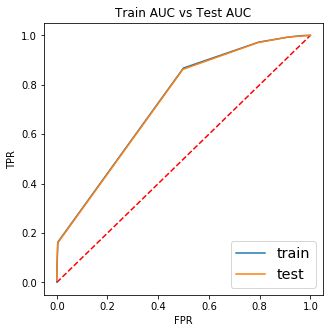

In [118]:
fpr_train.append(0)
tpr_train.append(0)
fpr_test.append(0)
tpr_test.append(0)
plt.figure(figsize=(5,5))
plt.plot([0, 1], [0, 1], 'r--')
plt.plot(fpr_train,
         tpr_train, label = 'train')
plt.plot(fpr_test,
         tpr_test, label = 'test')
legend = plt.legend(loc='lower right', shadow=False, fontsize='x-large')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Train AUC vs Test AUC')
plt.show()

In [119]:
#####This part is used to to obtain model trainning fpr and tpr wrt. different thresholds
example_class = ['severe_toxic']
train=rescaledData.select("features",name)
test = rescaledData_test.select("features",name)
ratio=weight_ratio(train,name)
train=train.withColumn("weight", F.when(train[name]==1,ratio).otherwise(1))
lr = LogisticRegression(featuresCol = 'features',weightCol="weight",labelCol = name, maxIter=10,regParam = 0.03, elasticNetParam =1, threshold = th)
lrModel = lr.fit(train)
#predictions_train = lrModel.transform(train)

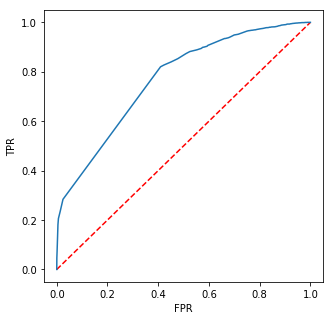

In [121]:
fpr = lrModel.summary.roc.select('FPR').collect()
tpr = lrModel.summary.roc.select('TPR').collect()
plt.figure(figsize=(5,5))
plt.plot([0, 1], [0, 1], 'r--')
plt.plot(fpr,
         tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()